In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Resizing,Rescaling,Conv2D,Flatten,BatchNormalization,MaxPool2D,Dropout,InputLayer,Dense
from keras.regularizers import L2
from keras.metrics import CategoricalAccuracy ,TopKCategoricalAccuracy
from keras.optimizers import Adam
import cv2

In [2]:
train_directory="/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train"
validation_directory="/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES=["angry","happy","sad"]
CONFIGURATION={
        "BATCH_SIZE":32,
        "IMG_SIZE":256,
        "REGULARIZATION_RATE": 0.0,
      "N_FILTERS": 6,
      "KERNEL_SIZE": 3,
      "N_STRIDES": 1,
      "POOL_SIZE": 2,
      "N_DENSE_1": 100,
      "N_DENSE_2": 10,
    "DROPOUT_RATE": 0.0,
    "NUM_CLASSES":3,
    "LEARNING_RATE":0.001,
    "EPOCHS":10

}

In [3]:
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=42,
  
    
)


Found 6799 files belonging to 3 classes.


In [4]:
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=42,
)


Found 2278 files belonging to 3 classes.


In [5]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 18.       ,  18.       ,  18.       ],
         [ 20.4375   ,  20.4375   ,  20.4375   ],
         [ 23.0625   ,  23.0625   ,  23.0625   ],
         ...,
         [  4.3125   ,   4.3125   ,   4.3125   ],
         [  5.375    ,   5.375    ,   5.375    ],
         [  7.       ,   7.       ,   7.       ]],

        [[ 12.3125   ,  12.3125   ,  12.3125   ],
         [ 13.4296875,  13.4296875,  13.4296875],
         [ 14.6328125,  14.6328125,  14.6328125],
         ...,
         [  4.3125   ,   4.3125   ,   4.3125   ],
         [  5.375    ,   5.375    ,   5.375    ],
         [  7.       ,   7.       ,   7.       ]],

        [[ 13.75     ,  13.75     ,  13.75     ],
         [ 14.003906 ,  14.003906 ,  14.003906 ],
         [ 13.8046875,  13.8046875,  13.8046875],
         ...,
         [  4.3125   ,   4.3125   ,   4.3125   ],
         [  5.5039062,   5.5039062,   5.5039062],
         [  7.6875   ,   7.6875   ,   7.6875

# Dataset Visualization

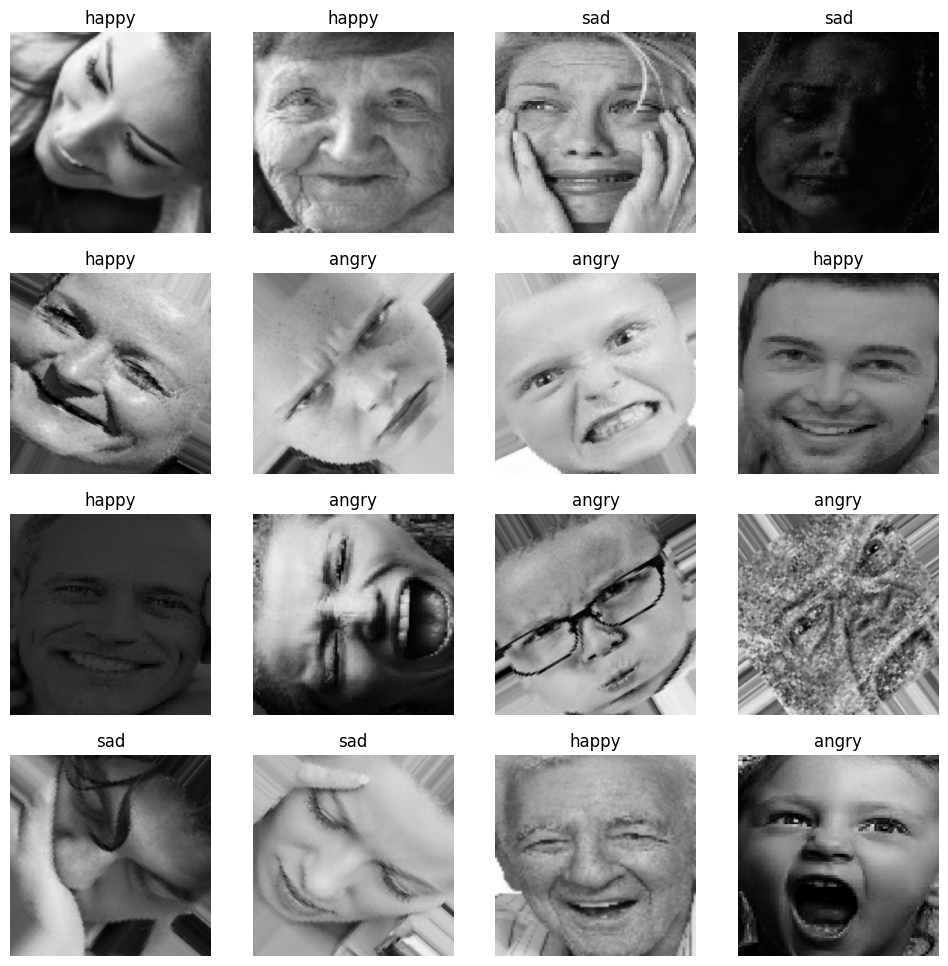

In [6]:
plt.figure(figsize=(12,12))
for images,labels in train_dataset.take(1):
    for i in range(16):
        po=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
        plt.axis("off")
        
        

In [7]:
train_dataset=(
    train_dataset.prefetch(tf.data.AUTOTUNE)
)

#### > So, in summary, the line train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE) is optimizing your training data pipeline by prefetching batches of data in the background while the model is training, potentially reducing training time by keeping the GPU or CPU busy with data processing tasks.

In [8]:
validation_dataset=(
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [9]:
resize_rescale_layers=tf.keras.Sequential([
    Resizing(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    Rescaling(1./255)
])

# <b>Modeling<b>
    

In [23]:
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']
lenet_model=tf.keras.Sequential(
[
    InputLayer(input_shape=(None,None,3)),
    resize_rescale_layers,
    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),
    
    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(3, activation = "softmax"),
    
    
    
]
)
lenet_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     6,150,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

## <b> Training <b>
    
    

In [24]:
loss_function=tf.keras.losses.CategoricalCrossentropy(
  
)


In [12]:
metrics=[CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2,name="top_K_accuracy")]

In [26]:
lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=loss_function,
    metrics=metrics
)


In [27]:
history=lenet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=CONFIGURATION['EPOCHS'],
    verbose=1
)

Epoch 1/10
  5/213 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6903 - loss: 1.7517 - top_K_accuracy: 0.8849

W0000 00:00:1711814787.685727      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6012 - loss: 1.1753 - top_K_accuracy: 0.8426

W0000 00:00:1711814799.293378      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.6012 - loss: 1.1745 - top_K_accuracy: 0.8426 - val_accuracy: 0.4745 - val_loss: 1.0515 - val_top_K_accuracy: 0.7739
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7139 - loss: 0.6724 - top_K_accuracy: 0.9156 - val_accuracy: 0.6124 - val_loss: 0.8624 - val_top_K_accuracy: 0.8701
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.8393 - loss: 0.4204 - top_K_accuracy: 0.9622 - val_accuracy: 0.4363 - val_loss: 1.0901 - val_top_K_accuracy: 0.6809
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9221 - loss: 0.2447 - top_K_accuracy: 0.9888 - val_accuracy: 0.6651 - val_loss: 0.9071 - val_top_K_accuracy: 0.8635
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9457 - loss: 0.1696 - top_K_accuracy: 0.9929 - val_accuracy: 0.5610 - val_loss: 1.1432 - val_top_K_accuracy: 0.8178
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9543 - loss: 0.1468 - t

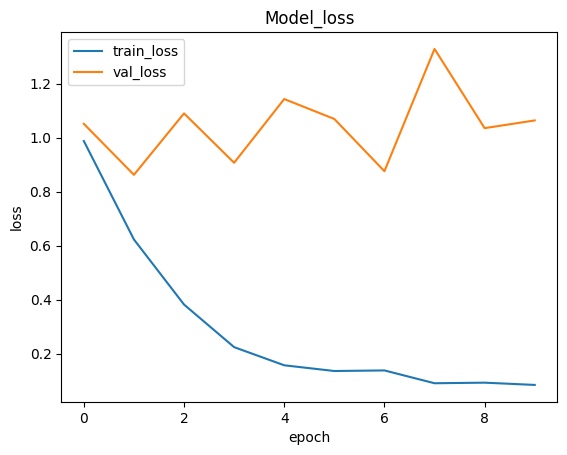

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title("Model_loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss","val_loss"])
plt.show()

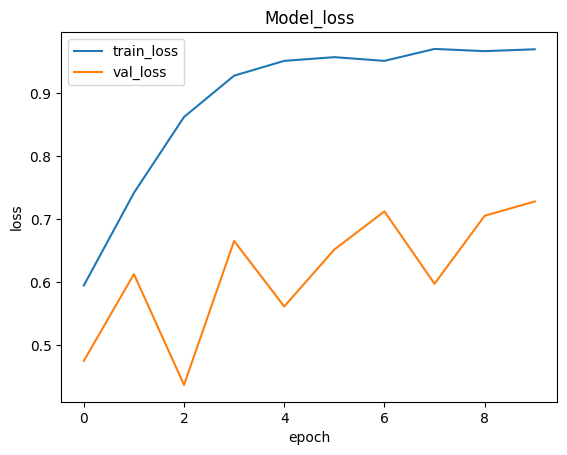

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title("Model_loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss","val_loss"])
plt.show()

In [30]:
lenet_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7259 - loss: 1.0465 - top_K_accuracy: 0.9025


[1.0658849477767944, 0.7278314232826233, 0.8999121785163879]

### <b> Testing </b>

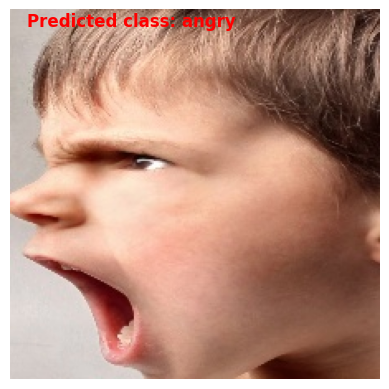

In [38]:
test_image=cv2.imread("/kaggle/input/human-emotions-datasethes/EmotionsDataset/data/angry/1.jpg")
im =tf.constant(test_image,dtype=tf.float32)
im=tf.expand_dims(im,axis=0)
predictions=lenet_model(im)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name=CLASS_NAMES[predicted_class_index]
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis("off")

# Add the predicted class name as text on the image
plt.text(10, 10, "Predicted class: " + predicted_class_name, color='red', fontsize=12, weight='bold')

plt.show()

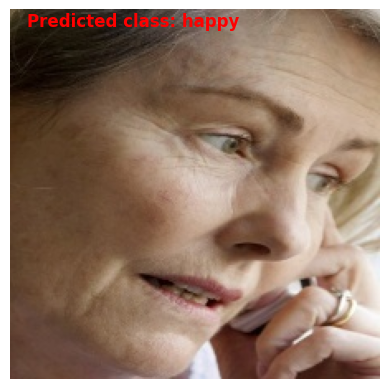

In [39]:
test_image=cv2.imread("/kaggle/input/human-emotions-datasethes/EmotionsDataset/data/happy/100.jpg")
im =tf.constant(test_image,dtype=tf.float32)
im=tf.expand_dims(im,axis=0)
predictions=lenet_model(im)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name=CLASS_NAMES[predicted_class_index]
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis("off")

# Add the predicted class name as text on the image
plt.text(10, 10, "Predicted class: " + predicted_class_name, color='red', fontsize=12, weight='bold')

plt.show()

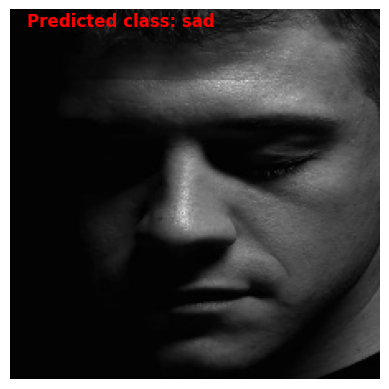

In [41]:
test_image=cv2.imread("/kaggle/input/human-emotions-datasethes/EmotionsDataset/data/sad/106.jpg")
im =tf.constant(test_image,dtype=tf.float32)
im=tf.expand_dims(im,axis=0)
predictions=lenet_model(im)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name=CLASS_NAMES[predicted_class_index]
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis("off")

# Add the predicted class name as text on the image
plt.text(10, 10, "Predicted class: " + predicted_class_name, color='red', fontsize=12, weight='bold')

plt.show()